In [11]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np 
import helper
from datetime import datetime
from matplotlib import pyplot as plt


# Datos


Los datos serán almacenados en memoria en 5 Data Frames distintos, los cuales contendrán la información vinculada a:

- Personas: Id, Fecha de Nacimiento, Género, Código Postal.
- Usuarios (Personas): Id(Personas), Ocupación, Fecha de Alta.
- Trabajadores (Personas): Id(Personas), Fecha de Alta, Puesto, Categoría, Horario de Trabajo.  
- Películas: Nombre, Año, Género(s), id.  
- Scores: Usuario (Id), Película (Id), Puntuación, Timestamp

In [2]:
personas_db = pd.read_csv("../Data/personas.csv")
personas_db.head()

,id,Full Name,year of birth,Gender,Zip Code
0,1,Robert Stanley,1974,M,85711
1,2,Heather Bossey,1945,F,94043
2,3,Don Davis,1975,M,32067
3,4,Daniel Mccauley,1974,M,43537
4,5,Janice Mccullough,1965,F,15213


In [3]:
usuarios_db = pd.read_csv("../Data/usuarios.csv")
usuarios_db.head()

,id,Occupation,Active Since
0,1,technician,1997-09-22 21:57:58
1,2,other,1998-02-27 03:26:00
2,3,writer,1998-03-07 02:15:39
3,4,technician,1998-04-08 02:09:34
4,5,other,1997-09-30 15:57:44


In [4]:
trabajadores_db = pd.read_csv("../Data/trabajadores.csv")
trabajadores_db.head()

,id,Position,Category,Working Hours,Start Date
0,16,Analyst,B,9 - 18,1998-03-30
1,31,Analyst,A,9 - 18,1997-09-25
2,167,Analyst,B,7 - 16,1997-10-24
3,183,Analyst,C,20 - 04,1998-01-26
4,298,Analyst,C,9 - 18,1997-10-18


In [6]:
scores_db = pd.read_csv("../Data/scores.csv")
scores_db = scores_db.drop(columns="Unnamed: 0")
scores_db.head()

,user_id,movie_id,rating,Date
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


# CLASE PELICULA


In [22]:
import helper

class Pelicula:
    def __init__(self, nombre, anio, generos, id = None):
        self.nombre = nombre
        self.anio = anio
        self.generos = generos
        self.id = id

    def __repr__(self):
        # Este método debe imprimir la información de esta película.
        output = f"Nombre: {self.nombre}\nAño: {self.anio}\nGenero: {self.generos}"
        return output    

    def write_df(self, df_mov):
        # Este método recibe el dataframe de películas y agrega la película
        # Si el id es None, toma el id más alto del DF y le suma uno. Si el 
        # id ya existe, no la agrega y devuelve un error.
        if self.id in df_mov["id"].values: return -1        
        if self.id is None: self.id = df_mov["id"].max() + 1 if not df_mov.empty else 1  
        new_row = helper.parse_movie(self, df_mov)      #todo/ validar posible error
        df_mov.loc[len(df_mov)] = new_row   
        return df_mov

    @classmethod
    def create_df_from_csv(cls, filename):
        # Este class method recibe el nombre de un archivo csv, valida su estructura 
        # y devuelve un DataFrame con la información cargada del archivo 'filename'.        
        try:
            df = pd.read_csv(filename)            
            if (df.columns.tolist() !=  helper.get_movies_structure()):                
                raise ValueError("El archivo CSV no contiene todas las columnas requeridas.")
            return df        
        except Exception as e:
            print(f"Error al procesar el archivo CSV '{filename}': {str(e)}")
            return None

    @classmethod
    def get_from_df(cls, df_mov, id=None, nombre=None, anios=None, generos=None):
        # Este class method devuelve una lista de objetos 'Pelicula' buscando por:
        # id, nombre, anios: [desde_año, hasta_año], generos: [generos]
        mask = helper.get_df_from_df(df_mov,id=id,nombre=nombre,anios=anios,generos=generos)
        peliculas = []
        for index, row in mask.iterrows():
            pelicula = cls(id=row['id'], nombre = row["Name"],anio=helper.get_year_from_df(row['Release Date']), generos = helper.gen_from_one_hot(row))
            peliculas.append(pelicula)        
        return peliculas
    
    @classmethod
    def get_stats(cls, df_mov, anios=None, generos=None):
        # Este class method imprime una serie de estadísticas calculadas sobre
        # los resultados de una consulta al DataFrame df_mov. 
        # Las estadísticas se realizarán sobre las filas que cumplan con los requisitos de:
        # anios: [desde_año, hasta_año]
        # generos: [generos]
        # Las estadísticas son:
        # - Datos película más vieja
        # - Datos película más nueva
        # - Bar plots con la cantidad de películas por año/género.

        # movies_selected = cls.get_from_df(df_mov, anios = anios, generos = generos)
        movies_selected = helper.get_df_from_df(df_mov,anios=anios,generos=generos)
        movies_selected["Fecha"] = movies_selected["Release Date"].apply(lambda x:datetime.strptime(x,"%d-%b-%Y"))
        movies_selected["Anio"] = movies_selected["Release Date"].apply(lambda x: int(x[-4:]))
        movies_selected = movies_selected.reset_index(drop=True)
        
        # pelicula_mas_vieja
        row = movies_selected.iloc[movies_selected["Fecha"].idxmin()]
        print("Película más vieja:")
        pelicula_mas_vieja = cls(id=row['id'], nombre = row["Name"],anio=helper.get_year_from_df(row['Release Date']), generos = helper.gen_from_one_hot(row))
        print(pelicula_mas_vieja)
        
        # pelicula_mas_vieja
        row = movies_selected.iloc[movies_selected["Fecha"].idxmax()]
        print("Película más nueva:")
        pelicula_mas_nueva = cls(id=row['id'], nombre = row["Name"],anio=helper.get_year_from_df(row['Release Date']), generos = helper.gen_from_one_hot(row))
        print(pelicula_mas_nueva)
        
        #grafico de generos
        plt.figure(figsize=(10, 6))
        conteo_generos = movies_selected[helper.get_gens()].sum()
        conteo_generos.plot(kind='bar')
        plt.title('Cantidad de películas por genero')
        plt.xlabel('Genero')
        plt.ylabel('Cantidad de películas')
        plt.show()

        #grafico de anios
        plt.figure(figsize=(10, 6))
        movies_selected['Anio'].value_counts().sort_index().plot(kind='bar')
        plt.title('Cantidad de películas por año')
        plt.xlabel('Año')
        plt.ylabel('Cantidad de películas')
        plt.show()
        

Película más vieja:
Nombre: Adventures of Robin Hood, The (1938)
Año: 1938
Genero: ['Action', 'Adventure']
Película más nueva:
Nombre: Lost in Space (1998)
Año: 1998
Genero: ['Action', 'Sci-Fi', 'Thriller']


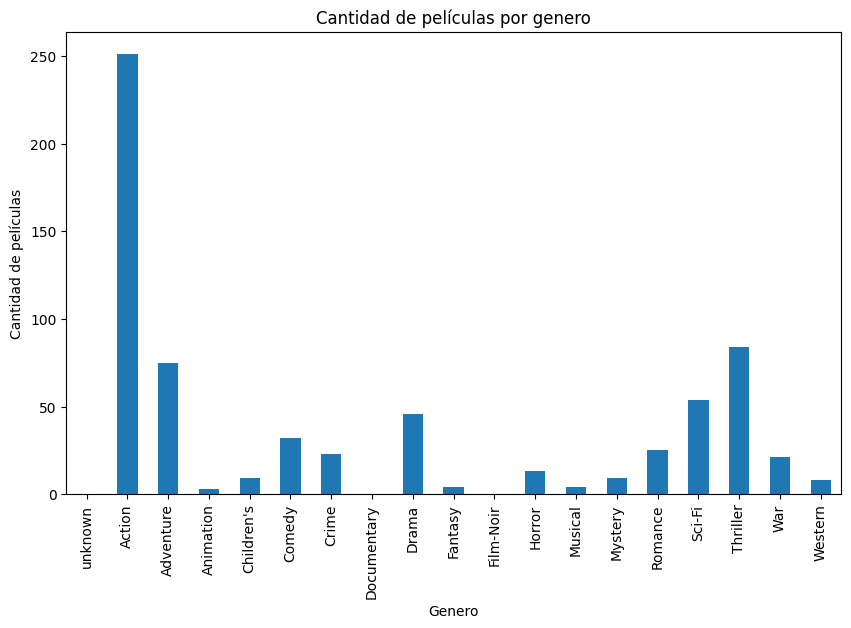

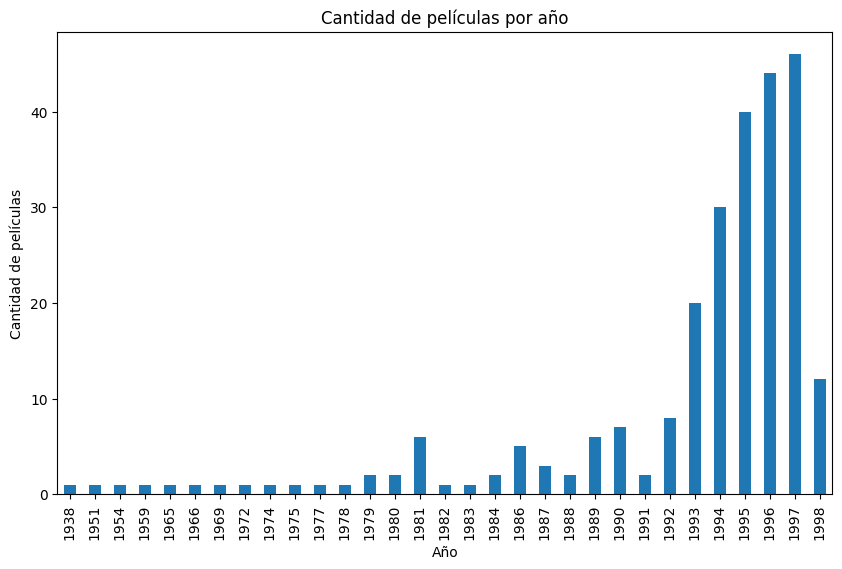

In [25]:
peliculas_db = Pelicula.create_df_from_csv("../Data/peliculas.csv")

peli = Pelicula("Rocky VII", 2010, ["Action","Drama","Thriller"])

pelis_short = peliculas_db.head(3)

peli.write_df(pelis_short)

# Pelicula.get_from_df(pelis_short,anios=[1994,2000],generos=['Action'])
Pelicula.get_stats(peliculas_db,generos=["Action"])